In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import arviz as az
import pymc as pm
import matplotlib.pyplot as plt

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
PATH = 'data/New_DB.xlsx'
df = pd.read_excel(PATH)

In [3]:
columns =['slope', 'PP', 'valor_humedad_suelo1']
X = df.loc[:,columns]

In [4]:
df_general = X
n_df_general = X * 0.9
df_general['output'] = 1
n_df_general['output'] = 0

df_output = pd.concat([df_general, n_df_general])

In [5]:
df_output.isnull().sum()

slope                     2
PP                        0
valor_humedad_suelo1    276
output                    0
dtype: int64

In [6]:
X_slope_PP = df_output.drop('valor_humedad_suelo1', axis=1)
X_slope_PP_vhs1 = df_output

In [7]:
X_slope_PP = X_slope_PP.dropna()
X_slope_PP_vhs1 = X_slope_PP_vhs1.dropna()
X_slope_PP = X_slope_PP.reset_index(drop=True)
X_slope_PP_vhs1 = X_slope_PP_vhs1.reset_index(drop=True)

In [8]:
X_slope_PP.shape, X_slope_PP_vhs1.shape

((832, 3), (558, 4))

In [9]:
y_slope_PP = X_slope_PP.output
X_slope_PP = X_slope_PP.drop(labels='output', axis=1)

y_slope_PP_vhs1 = X_slope_PP_vhs1.output
X_slope_PP_vhs1 = X_slope_PP_vhs1.drop(labels='output', axis=1)

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pytensor
import pytensor.tensor as pt
# TODO:
#   Separar el train con y sin vhs y definir correctamente nombre de variables
#   Intentar formato floatX de la forma:
#                                       floatX = pytensor.config.floatX
#                                       "X.astype(floatX)"
sc = StandardScaler()
floatX = pytensor.config.floatX
X_slope_PP_vhs1 = X_slope_PP_vhs1.astype(floatX)
y_slope_PP_vhs1 = y_slope_PP_vhs1.astype(floatX)
X_train, X_test, y_train, y_test = train_test_split(X_slope_PP_vhs1, y_slope_PP_vhs1, train_size=0.7, stratify=y_slope_PP_vhs1, random_state=42)
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [11]:
random_seed = 12
rng = np.random.default_rng(random_seed)

In [12]:
def construct_nn(ann_input, ann_output):
    n_hidden = 5

    # Initialize random weights between each layer
    init_1 = rng.standard_normal(size=(X_train.shape[1], n_hidden)).astype(floatX)
    init_2 = rng.standard_normal(size=(n_hidden, n_hidden)).astype(floatX)
    init_out = rng.standard_normal(size=n_hidden).astype(floatX)

    coords = {
        "hidden_layer_1": np.arange(n_hidden),
        "hidden_layer_2": np.arange(n_hidden),
        "train_cols": np.arange(X_train.shape[1]),
        # "obs_id": np.arange(X_train.shape[0]),
    }
    with pm.Model(coords=coords) as neural_network:
        ann_input = pm.Data("ann_input", X_train, mutable=True, dims=("obs_id", "train_cols"))
        ann_output = pm.Data("ann_output", y_train, mutable=True, dims="obs_id")

        # Weights from input to hidden layer
        weights_in_1 = pm.Normal(
            "w_in_1", 0, sigma=1, initval=init_1, dims=("train_cols", "hidden_layer_1")
        )

        # Weights from 1st to 2nd layer
        weights_1_2 = pm.Normal(
            "w_1_2", 0, sigma=1, initval=init_2, dims=("hidden_layer_1", "hidden_layer_2")
        )

        # Weights from hidden layer to output
        weights_2_out = pm.Normal("w_2_out", 0, sigma=1, initval=init_out, dims="hidden_layer_2")

        # Build neural-network using tanh activation function
        act_1 = pm.math.tanh(pm.math.dot(ann_input, weights_in_1))
        act_2 = pm.math.tanh(pm.math.dot(act_1, weights_1_2))
        act_out = pm.math.sigmoid(pm.math.dot(act_2, weights_2_out))

        # Binary classification -> Bernoulli likelihood
        out = pm.Bernoulli(
            "out",
            act_out,
            observed=ann_output,
            total_size=y_train.shape[0],  # IMPORTANT for minibatches
            dims="obs_id",
        )
    return neural_network


neural_network = construct_nn(X_train, y_train)

In [13]:
%%time
with neural_network:
    approx = pm.fit(n=10_000)

Interrupted at 297 [2%]: Average Loss = 354.28


CPU times: total: 15.6 s
Wall time: 15.6 s


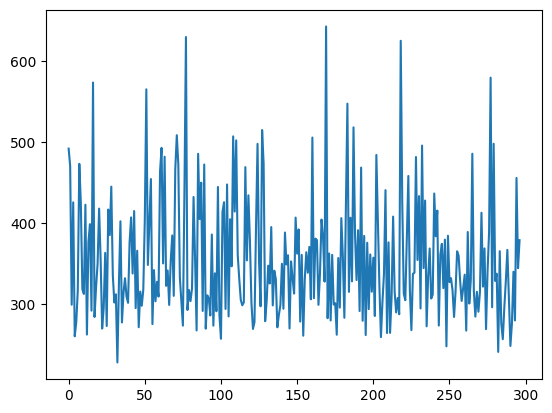

In [14]:
plt.plot(approx.hist)

In [15]:
trace = approx.sample(draws=5000)

In [16]:
with neural_network:
    pm.set_data(new_data={"ann_input": X_test})
    ppc = pm.sample_posterior_predictive(trace)
    trace.extend(ppc)

Sampling: [out]


In [17]:
pred = ppc.posterior_predictive["out"].mean(("chain", "draw")) > 0.50
print(f"Accuracy = {(y_test == pred.values).mean() * 100}%")

Accuracy = 68.45238095238095%


In [ ]:
X_train

array([[ 1.5951236 , -0.79059004, -0.56115686],
       [ 0.08544225, -0.62395294,  1.91257742],
       [-0.0086636 ,  2.01502272,  0.57054062],
       ...,
       [ 0.89638573, -0.82875774, -1.3257493 ],
       [-0.29029637,  2.68331237,  1.14792506],
       [-0.21558164, -0.82721909, -1.01239764]])

In [18]:
import bambi as bmb
X_train, X_test, y_train, y_test = train_test_split(X_slope_PP_vhs1, y_slope_PP_vhs1, train_size=0.7, stratify=y_slope_PP_vhs1, random_state=42)

slope_mean = X_train['slope'].mean()
slope_std = X_train['slope'].std()

PP_mean = X_train['PP'].mean()
PP_std = X_train['PP'].std()

#vhs1_mean = X_train['valor_humedad_suelo1'].mean()
#vhs1_std = X_train['valor_humedad_suelo1'].std()

#X_train['slope'] = (X_train['slope'] - slope_mean) / slope_std
#X_test['slope'] = (X_test['slope'] - slope_mean) / slope_std

#X_train['PP'] = (X_train['PP'] - PP_mean) / PP_std
#X_test['PP'] = (X_test['PP'] - PP_mean) / PP_std

#X_train['valor_humedad_suelo1'] = (X_train['valor_humedad_suelo1'] - vhs1_mean) / vhs1_std
#X_test['valor_humedad_suelo1'] = (X_test['valor_humedad_suelo1'] - vhs1_mean) / vhs1_std

#X_train['PP_2'] = X_train['valor_humedad_suelo1'] / X_train['PP'] 
#X_test['PP_2'] = X_test['valor_humedad_suelo1'] / X_test['PP'] 


X_train = pd.concat([X_train, y_train], axis=1)

In [ ]:
slope_mean, slope_std

(41.42002598164937, 13.117719634164368)

In [ ]:
model1 = bmb.Model("output ~ (slope + PP + valor_humedad_suelo1)", X_train, family="bernoulli", link= 'logit')
fitted1 = model1.fit(draws=1000,tune=1000, idata_kwargs={"log_likelihood": True})

Modeling the probability that output==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, slope, PP, valor_humedad_suelo1]


ValueError: Not enough samples to build a trace.

Sampling: [Intercept, PP, slope, valor_humedad_suelo1]


array([<Axes: title={'center': 'Intercept'}>,
       <Axes: title={'center': 'slope'}>, <Axes: title={'center': 'PP'}>,
       <Axes: title={'center': 'valor_humedad_suelo1'}>], dtype=object)

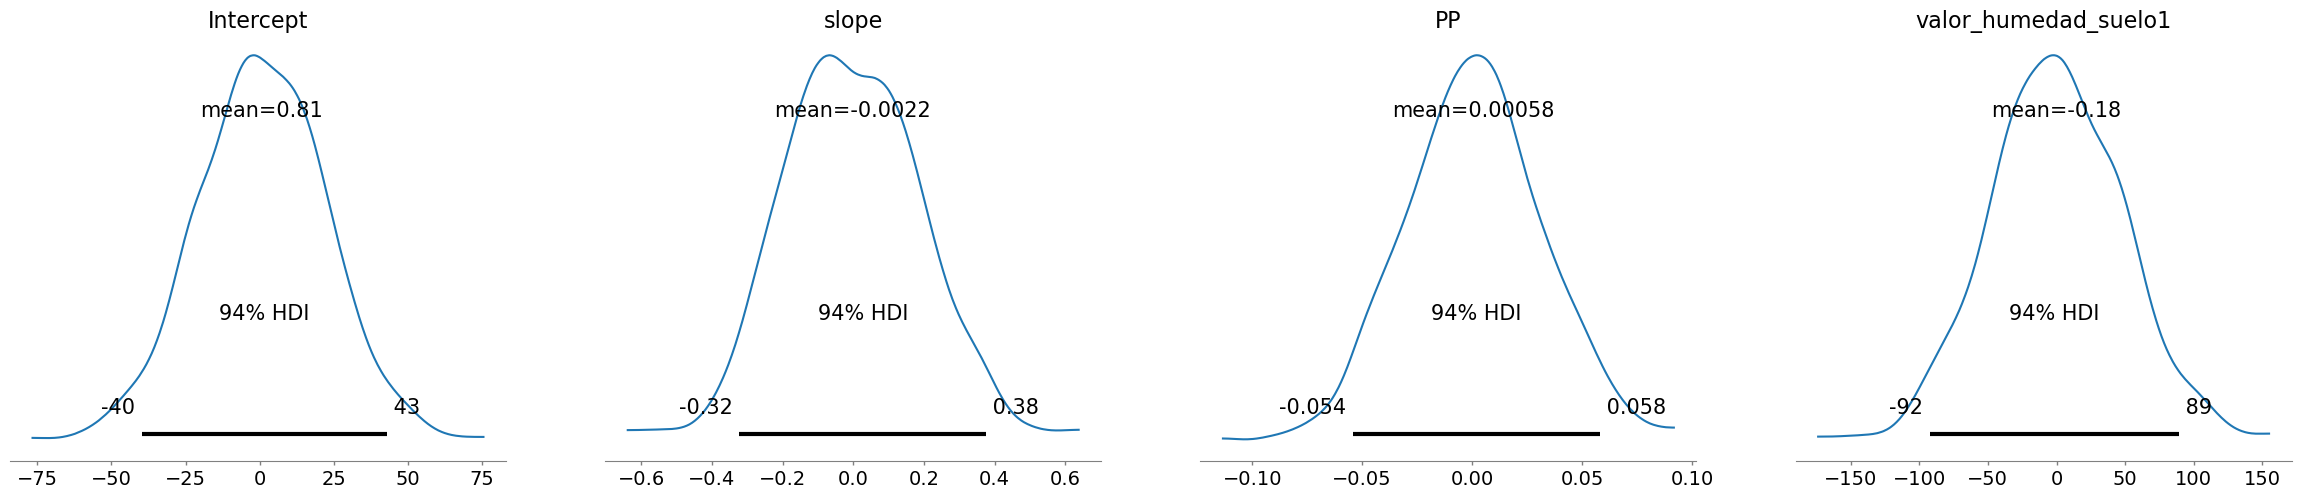

In [ ]:
model1.plot_priors(draws=1000)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-10.805,1.343,-13.295,-8.337,0.021,0.015,4298.0,3266.0,1.0
slope,0.030,0.009,0.014,0.047,0.000,0.000,6599.0,3354.0,1.0
PP,-0.003,0.001,-0.005,0.000,0.000,0.000,4304.0,3100.0,1.0
valor_humedad_suelo1,23.773,3.154,18.201,29.902,0.048,0.035,4292.0,3020.0,1.0


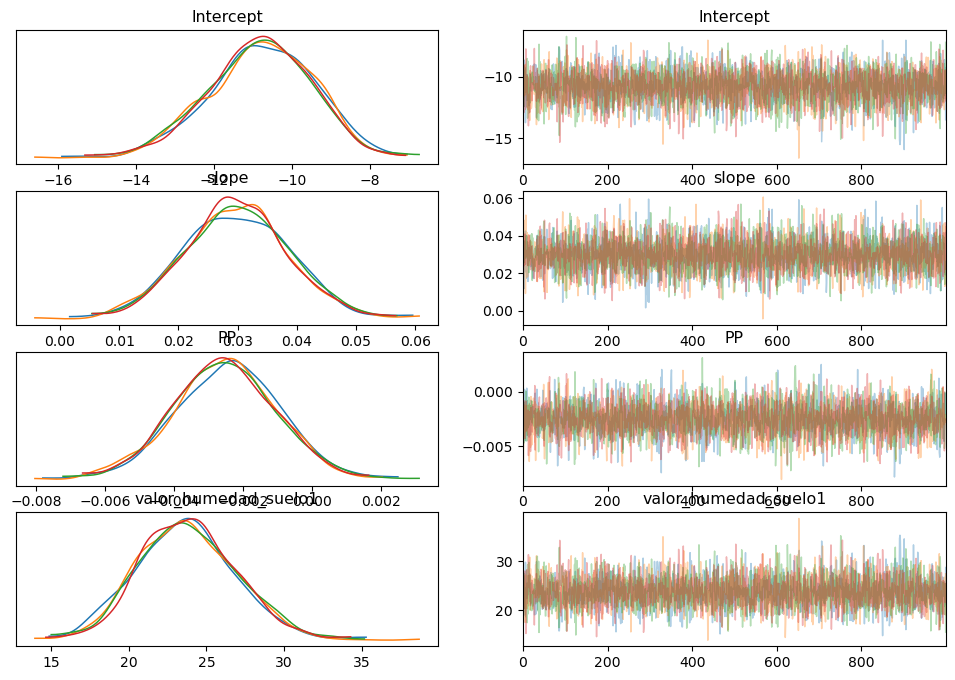

In [ ]:
az.plot_trace(fitted1, compact = False);
az.summary(fitted1)

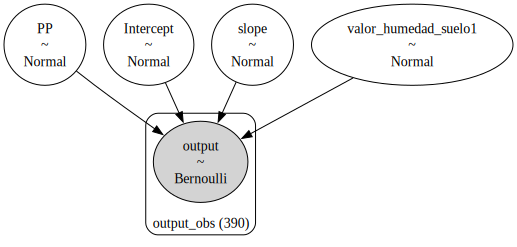

In [ ]:
model1.graph()

In [ ]:
pred = model1.predict(fitted1, data=X_test)
#print(f"Accuracy = {(y_test == pred.values).mean() * 100}%")

In [ ]:
pred = fitted1.posterior['output_mean'].mean(('chain', 'draw')) > 0.5

In [ ]:
print(f"Accuracy = {(y_test == pred.values).mean() * 100}%")

Accuracy = 80.35714285714286%


In [47]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

X_train, X_test, y_train, y_test = train_test_split(X_slope_PP_vhs1, y_slope_PP_vhs1, train_size=0.7, stratify=y_slope_PP_vhs1, random_state=42)
# Definir el modelo en PyMC3
"""with pm.Model() as modelo_bayesiano:
    # Priors para los coeficientes
    input = pm.Data("input", X_train, mutable=True)
    output = pm.Data("output", y_train, mutable= True)
    beta0 = pm.Normal('beta0', mu=0, sigma=10)
    beta_slope = pm.Normal('beta_slope', mu=0, sigma=10)
    beta_PP = pm.Normal('beta_PP', mu=0, sigma=10)
    beta_humedad = pm.Normal('beta_humedad', mu=0, sigma=10)

    # Modelo lineal
    logit = beta0 + beta_slope * input['slope'] + beta_PP * input['PP'] + beta_humedad * input['valor_humedad_suelo1']

    # Likelihood
    output_observed = pm.Bernoulli('output_observed', logit_p=logit, observed=output)

    # Muestrear el modelo
    #trace = pm.sample(2000, tune=1000)

pm.model_to_graphviz(modelo_bayesiano)
"""




'with pm.Model() as modelo_bayesiano:\n    # Priors para los coeficientes\n    input = pm.Data("input", X_train, mutable=True)\n    output = pm.Data("output", y_train, mutable= True)\n    beta0 = pm.Normal(\'beta0\', mu=0, sigma=10)\n    beta_slope = pm.Normal(\'beta_slope\', mu=0, sigma=10)\n    beta_PP = pm.Normal(\'beta_PP\', mu=0, sigma=10)\n    beta_humedad = pm.Normal(\'beta_humedad\', mu=0, sigma=10)\n\n    # Modelo lineal\n    logit = beta0 + beta_slope * input[\'slope\'] + beta_PP * input[\'PP\'] + beta_humedad * input[\'valor_humedad_suelo1\']\n\n    # Likelihood\n    output_observed = pm.Bernoulli(\'output_observed\', logit_p=logit, observed=output)\n\n    # Muestrear el modelo\n    #trace = pm.sample(2000, tune=1000)\n\npm.model_to_graphviz(modelo_bayesiano)\n'

In [48]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
def model_test(input, output):
    coords = {
        'train_cols': np.arange(X_train.shape[1]),
        #'obs_id': np.arange(X_train.shape[0])
    }
    with pm.Model(coords=coords) as model:
        input = pm.Data('input', X_train, mutable=True, dims=('obs_id','train_cols'))
        observed = pm.Data('observed', y_train, mutable=True, dims='dims_id')
        intercept = pm.Normal('intercept', mu=0,sigma=5)
        beta = pm.Normal('beta',mu=0, sigma=5)
        sigma = pm.Normal('sigma', mu=0, sigma=5)
        sigma_2 = pm.Normal('sigma_2', mu = 0, sigma=5)
        final = pm.Bernoulli('out',logit_p = intercept + input[:,0]*beta + input[:,1]*sigma + input[:,2]*sigma_2, observed = observed, dims='obs_id')
    return model

model_test = model_test(X_train, y_train)

In [ ]:
with model_test:
    approx = pm.fit(n=10_000)

Finished [100%]: Average Loss = 238.74


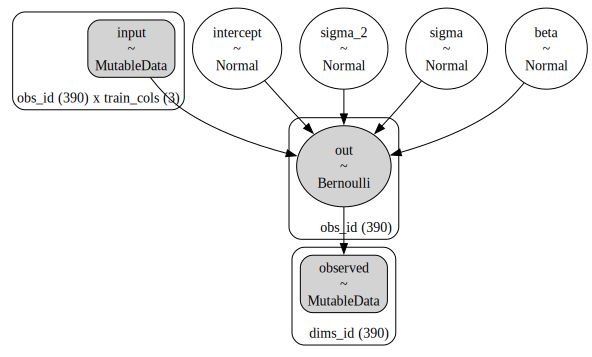

In [ ]:
pm.model_to_graphviz(model_test)

In [ ]:
trace = approx.sample(draws=5000)
#pred_trace = pm.sample(draws=1000,tune=1000,chains=2, cores = 6, init = 'adapt_diag')

In [ ]:
with model_test:
    pm.set_data(new_data={"input": X_test})
    ppc = pm.sample_posterior_predictive(trace)
    trace.extend(ppc)

Sampling: [out]


In [ ]:
X_train.shape, X_test.shape

((390, 3), (168, 3))

In [ ]:
pred = ppc.posterior_predictive["out"].mean(("chain", "draw")) > 0.50

In [ ]:
print(f"Accuracy = {(y_test == pred.values).mean() * 100}%")

Accuracy = 78.57142857142857%


In [45]:
def bayesian_regression_tree(input, output):
    coords = {
        'train_cols': np.arange(X_train.shape[1]),
        #'obs_id': np.arange(X_train.shape[0])
    }
    with pm.Model(coords=coords) as model:
        input = pm.Data('input', X_train, mutable=True, dims=('obs_id','train_cols'))
        observed = pm.Data('observed', y_train, mutable=True, dims='dims_id')
        intercept = pm.Normal('intercept', mu = 0, sigma = 5)
        beta = pm.Normal('beta',mu=0, sigma=5)
        beta2 = pm.Normal('beta2', mu=0, sigma=5)
        beta3 = pm.Normal('beta3', mu = 0, sigma=5)
        alpha = pm.Normal('alpha', mu = 0, sigma=0.1)
        alpha2 = pm.Normal('alpha2', mu = 0, sigma = 0.1)
        alpha3 = pm.Normal('alpha3', mu = 0, sigma=1)
        alpha4 = pm.Normal('alpha4', mu = 0, sigma = 0.1)
        alpha5 = pm.Normal('alpha5', mu = 0 , sigma = 1)
        alpha6 = pm.Normal('alpha6', mu = 0 , sigma = 1)
        p = pm.Deterministic(
            'p', 
            pm.math.invlogit(
                intercept + input[:,0]*beta + input[:,1]*beta2 + input[:,2]*beta3 + 
                (input[:,1]**2)*alpha**2 + (input[:,2]**2)*alpha2**2 + (input[:,0]**2)*alpha3**2 + 
                (input[:,1]**2)*alpha4**3 + (input[:,2]**3)*alpha5**3 + (input[:,0]**3)*alpha6**3))
        final = pm.Bernoulli('out',p , observed = observed, dims='obs_id')
        
    return model

bayesian_regression_tree = bayesian_regression_tree(X_train, y_train)

In [46]:
with bayesian_regression_tree:
    start = pm.find_MAP()
    #hessian_inv = np.linalg.inv(pm.find_hessian(start, model=bayesian_regression_tree))
    #approx = pm.fit(n=10_000, start=start)
    step = pm.Metropolis()
    trace = pm.sample(draws=5000, step = step, start = start)# nuts_sampler_kwargs={'hess_inv': hessian_inv})

with bayesian_regression_tree:
    pm.set_data(new_data={"input": X_test})
    ppc = pm.sample_posterior_predictive(trace, var_names=['p'], return_inferencedata=True, predictions=True, extend_inferencedata=True)
    trace.extend(ppc)
#pred = ppc.posterior_predictive["out"].mean(("chain", "draw")) > 0.50
#print(f"Accuracy = {(y_test == pred.values).mean() * 100}%")
pred = ppc.predictions['p'].mean(('chain', 'draw')) > 0.5
print(f"Accuracy = {(y_test == pred.values).mean() * 100}%")

c:\Users\ivo\.conda\envs\fjerez_mlabbe\lib\site-packages\pytensor\scalar\basic.py:2004: RuntimeWarning: invalid value encountered in divide
  return x / y


C:\Users\ivo\AppData\Local\Temp\ipykernel_18088\2638288232.py:6: FutureWarning: The `start` kwarg was renamed to `initvals` and can now do more. Please check the docstring.
  trace = pm.sample(draws=5000, step = step, start = start)# nuts_sampler_kwargs={'hess_inv': hessian_inv})
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc.sampling.mcmc:Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
INFO:pymc.sampling.mcmc:CompoundStep
>Metropolis: [intercept]
INFO:pymc.sampling.mcmc:>Metropolis: [intercept]
>Metropolis: [beta]
INFO:pymc.sampling.mcmc:>Metropolis: [beta]
>Metropolis: [beta2]
INFO:pymc.sampling.mcmc:>Metropolis: [beta2]
>Metropolis: [beta3]
INFO:pymc.sampling.mcmc:>Metropolis: [beta3]
>Metropolis: [alpha]
INFO:pymc.sampling.mcmc:>Metropolis: [alpha]
>Metropolis: [alpha2]
INFO:pymc.sampling.mcmc:>Metropolis: [alpha2]
>Metropolis: [alpha3]
INFO:pymc.sampling.mcmc:>Metropolis: [alpha3]
>Metropolis: [alpha4]
INFO:pymc.sampling.mcmc:>Metropolis: [alpha4]
>Metropolis: [alpha

ValueError: Not enough samples to build a trace.

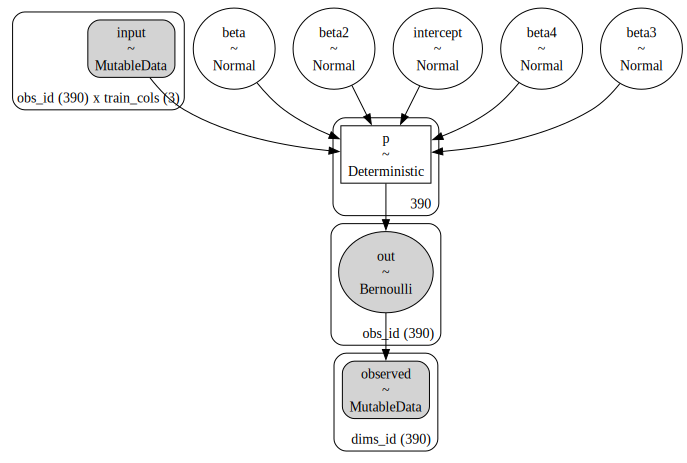

In [ ]:
pm.model_to_graphviz(bayesian_regression_tree)

In [ ]:
trace = approx.sample(draws=5000)
with bayesian_regression_tree:
    pm.set_data(new_data={"input": X_test})
    ppc = pm.sample_posterior_predictive(trace, var_names=['p'], return_inferencedata=True, predictions=True, extend_inferencedata=True)
    trace.extend(ppc)
#pred = ppc.posterior_predictive["out"].mean(("chain", "draw")) > 0.50
#print(f"Accuracy = {(y_test == pred.values).mean() * 100}%")
pred = ppc.predictions['p'].mean(('chain', 'draw')) > 0.50
print(f"Accuracy = {(y_test == pred.values).mean() * 100}%")

Sampling: []


Accuracy = 81.54761904761905%


In [ ]:
az.summary(ppc).round(2)

arviz - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
out[0],0.59,0.49,0.0,1.0,0.01,0.0,4828.0,4828.0,NaN
out[1],0.75,0.43,0.0,1.0,0.01,0.0,4827.0,4827.0,NaN
out[2],0.51,0.50,0.0,1.0,0.01,0.0,5024.0,5000.0,NaN
out[3],0.66,0.47,0.0,1.0,0.01,0.0,5124.0,5000.0,NaN
out[4],0.67,0.47,0.0,1.0,0.01,0.0,4940.0,4940.0,NaN
...,...,...,...,...,...,...,...,...,...
out[163],0.48,0.50,0.0,1.0,0.01,0.0,5152.0,5000.0,NaN
out[164],0.66,0.47,0.0,1.0,0.01,0.0,4962.0,4962.0,NaN
out[165],0.30,0.46,0.0,1.0,0.01,0.0,4712.0,4712.0,NaN
out[166],0.32,0.47,0.0,1.0,0.01,0.0,4410.0,4410.0,NaN


In [ ]:
trace = approx.sample(draws=5000)

In [ ]:
def binomial_regression_model(input, output):
    coords = {
        'train_cols': np.arange(X_train.shape[1]),
        #'obs_id': np.arange(X_train.shape[0])
    }
    with pm.Model(coords=coords) as model:
        input = pm.Data('input', X_train, mutable=True, dims=('obs_id','train_cols'))
        observed = pm.Data('observed', y_train, mutable=True, dims='dims_id')
        intercept = pm.Normal('intercept', mu = 0, sigma = 1)
        beta = pm.Normal('beta',mu=0, sigma=1)
        beta2 = pm.Normal('beta2', mu=0, sigma=1)
        beta3 = pm.Normal('beta3', mu = 0, sigma=1)
        p = pm.Deterministic(
            'p', 
            pm.math.invlogit(
                intercept + input[:,0]*beta + input[:,1]*beta2 + input[:,2]*beta3))
        final = pm.Bernoulli('out', p=p , observed = observed, dims='obs_id')
        
    return model

binomial_regression_model = binomial_regression_model(X_train, y_train)

In [ ]:
with binomial_regression_model:
    approx = pm.fit(n=10_000)

Finished [100%]: Average Loss = 233.1


In [ ]:

#start = pm.find_MAP()
#hessian_inv = np.linalg.inv(pm.find_hessian(start, model=bayesian_regression_tree))
#step = pm.Metropolis()
trace = approx.sample(draws=5000)# nuts_sampler_kwargs={'hess_inv': hessian_inv})

with binomial_regression_model:
    pm.set_data(new_data={"input": X_test})
    ppc = pm.sample_posterior_predictive(trace)
    trace.extend(ppc)
pred = ppc.posterior_predictive["out"].mean(("chain", "draw")) > 0.50
print(f"Accuracy = {(y_test == pred.values).mean() * 100}%")
#pred = ppc.predictions['p'].mean(('chain', 'draw')) > 0.5
#print(f"Accuracy = {(y_test == pred.values).mean() * 100}%")

Sampling: [out]


Accuracy = 79.76190476190477%


In [25]:
import pymc_bart as pmb
RANDOM_SEED = 42
with pm.Model() as model_oos_regression:
    X = pm.MutableData("X", X_train)
    Y = y_train
    α = pm.Exponential("α", 1)
    μ = pmb.BART("μ", X, Y)
    y = pm.NegativeBinomial("y", mu=pm.math.invlogit(μ), alpha=α, observed=Y, shape=μ.shape)
    idata_oos_regression = pm.sample(random_seed=RANDOM_SEED)
    posterior_predictive_oos_regression_train = pm.sample_posterior_predictive(
        trace=idata_oos_regression, random_seed=RANDOM_SEED
    )

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [α]
>PGBART: [μ]


ValueError: Not enough samples to build a trace.

In [ ]:
with model_oos_regression:
    X_set_values(X_test)
    posterior_predictive_oos_regression_test = pm.sample_posterior_predictive(trace.idata_oos_regression, random_seed=RANDOM_SEED)

In [ ]:
data = posterior_predictive_oos_regression_test

In [ ]:
fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(8, 7), sharex=True, sharey=True, layout="constrained"
)

az.plot_ppc(
    data=posterior_predictive_oos_regression_train, kind="cumulative", observed_rug=True, ax=ax[0]
)
ax[0].set(title="Posterior Predictive Check (train)", xlim=(0, 1_000))

az.plot_ppc(
    data=posterior_predictive_oos_regression_test, kind="cumulative", observed_rug=True, ax=ax[1]
)
ax[1].set(title="Posterior Predictive Check (test)", xlim=(0, 1_000));

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X_slope_PP_vhs1, y_slope_PP_vhs1, train_size=0.7, stratify=y_slope_PP_vhs1, random_state=42)
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [83]:
def model_w(input, output):
    coords = {
        'train_cols': np.arange(X_train.shape[1]),
        #'obs_id': np.arange(X_train.shape[0])
    }
    with pm.Model(coords=coords) as model:
        input = pm.Data('input', X_train, mutable=True, dims=('obs_id','train_cols'))
        observed = pm.Data('observed', y_train, mutable=True, dims='dims_id')
        intercept = pm.Normal('intercept', mu=0,sigma=10)
        
        beta1 = pm.Normal('beta',mu=0, sigma=5)
        beta2 = pm.Normal('beta2', mu=0, sigma=5)
        beta3 = pm.Normal('beta3', mu = 0, sigma=5)
        
        beta4 = pm.Normal('beat4', mu = 0, sigma = 0.1)
        beta5 = pm.Normal('beta5', mu = 0 , sigma = 1)
        
        final = pm.Bernoulli('out',
                             logit_p = intercept + input[:,0]*beta1 + input[:,1]*beta2 + input[:,2]*beta3 + 
                                (input[:,1]*beta4)**2 + (input[:,2]*beta5)**2,
                             observed = observed,
                             dims='obs_id')
    return model

model_w = model_w(X_train, y_train)

In [122]:
trace_df

,chain,draw,intercept,beta,beta2,beta3,beat4,beta5
0,0,0,-0.207689,0.428168,-0.204488,1.537656,-0.268926,0.593075
1,0,1,-0.068725,0.526396,-0.240212,1.217306,0.069591,0.429117
2,0,2,-0.355509,0.194372,-0.084312,1.307293,-0.136540,0.514673
3,0,3,-0.132188,0.561404,-0.457595,1.401108,0.284240,0.426736
4,0,4,-0.152378,0.541673,-0.462313,1.459667,0.349746,-0.183331
...,...,...,...,...,...,...,...,...
3995,39,995,-0.301301,0.294880,-0.329885,1.297018,-0.167767,0.506359
3996,39,996,-0.301301,0.294880,-0.329885,1.297018,-0.167767,0.506359
3997,39,997,-0.135624,0.524385,-0.161398,1.495948,0.058919,0.564727
3998,39,998,-0.065706,0.494702,-0.124513,1.080410,0.020973,0.511727


In [81]:
with model_w:
    approx = pm.fit(n=10_000)

trace = approx.sample(draws=5000)

with model_w:
    pm.set_data(new_data={"input": X_test})
    ppc = pm.sample_posterior_predictive(trace)
    trace.extend(ppc)

pred = ppc.posterior_predictive["out"].mean(("chain", "draw")) > 0.50
print(f"Accuracy = {(y_test == pred.values).mean() * 100}%")

Interrupted at 328 [3%]: Average Loss = 425.98
INFO:pymc.variational.inference:Interrupted at 328 [3%]: Average Loss = 425.98
Sampling: [out]
INFO:pymc.sampling.forward:Sampling: [out]


Accuracy = 54.761904761904766%


In [96]:
with model_w:
    trace = pm.sample(tune=1000,draws=1000,chains=4, init= 'adapt_diag', cores=8)

Auto-assigning NUTS sampler...
INFO:pymc.sampling.mcmc:Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
INFO:pymc.sampling.mcmc:Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 8 jobs)
INFO:pymc.sampling.mcmc:Multiprocess sampling (4 chains in 8 jobs)
NUTS: [intercept, beta, beta2, beta3, beat4, beta5]
INFO:pymc.sampling.mcmc:NUTS: [intercept, beta, beta2, beta3, beat4, beta5]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2654 seconds.
INFO:pymc.sampling.mcmc:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2654 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
INFO:pymc.stats.convergence:The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 628 divergen

In [97]:
with model_w:
    pm.set_data(new_data={"input": X_test})
    ppc = pm.sample_posterior_predictive(trace)
    trace.extend(ppc)

pred = ppc.posterior_predictive["out"].mean(("chain", "draw")) > 0.50
print(f"Accuracy = {(y_test == pred.values).mean() * 100}%")

Sampling: [out]
INFO:pymc.sampling.forward:Sampling: [out]


Accuracy = 82.14285714285714%


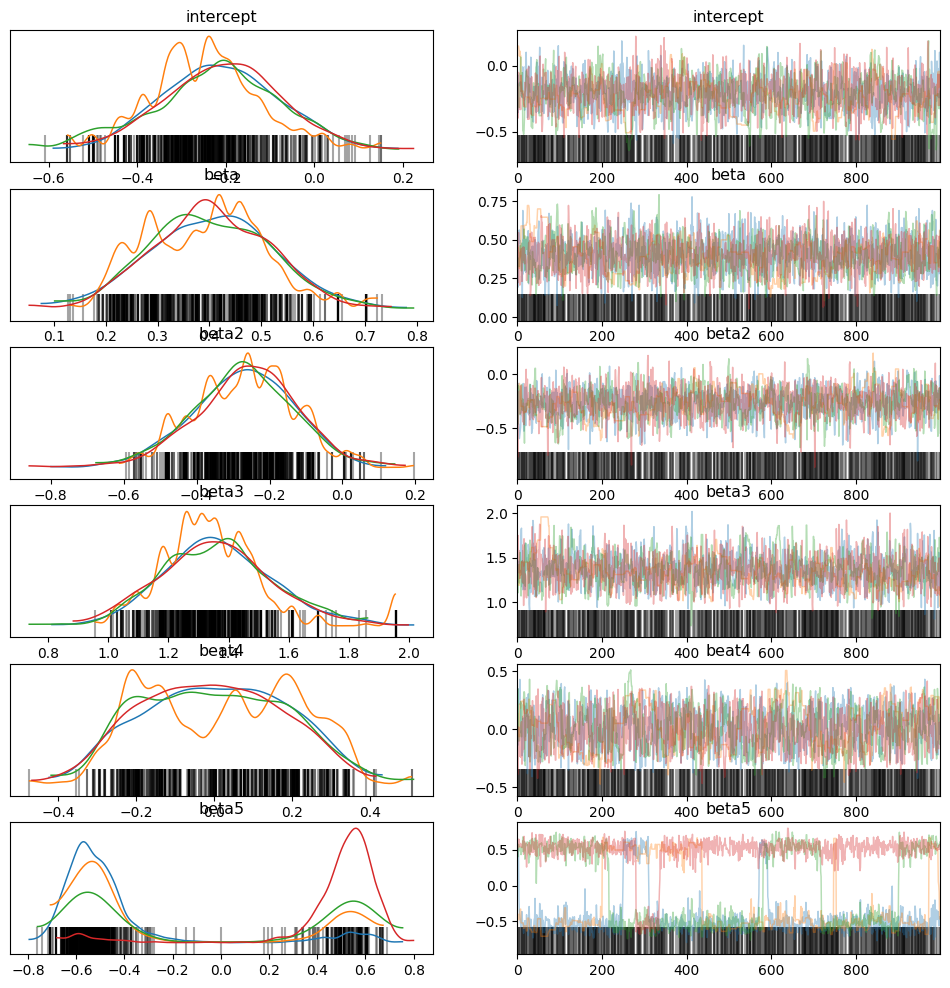

In [99]:
pm.plot_trace(trace, compact=False);

In [102]:
trace

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data
	> constant_data

In [105]:
trace_df = az.convert_to_inference_data(obj=trace).to_dataframe(include_coords=False,groups='posterior')

In [108]:
trace_df

,chain,draw,intercept,beta,beta2,beta3,beat4,beta5
0,0,0,-0.207689,0.428168,-0.204488,1.537656,-0.268926,0.593075
1,0,1,-0.068725,0.526396,-0.240212,1.217306,0.069591,0.429117
2,0,2,-0.355509,0.194372,-0.084312,1.307293,-0.136540,0.514673
3,0,3,-0.132188,0.561404,-0.457595,1.401108,0.284240,0.426736
4,0,4,-0.152378,0.541673,-0.462313,1.459667,0.349746,-0.183331
...,...,...,...,...,...,...,...,...
3995,39,995,-0.301301,0.294880,-0.329885,1.297018,-0.167767,0.506359
3996,39,996,-0.301301,0.294880,-0.329885,1.297018,-0.167767,0.506359
3997,39,997,-0.135624,0.524385,-0.161398,1.495948,0.058919,0.564727
3998,39,998,-0.065706,0.494702,-0.124513,1.080410,0.020973,0.511727


In [110]:
trace_df_long = pd.melt(trace_df, id_vars=['draw', 'chain'])

In [112]:
trace_df_long

,draw,chain,variable,value
0,0,0,intercept,-0.207689
1,1,0,intercept,-0.068725
2,2,0,intercept,-0.355509
3,3,0,intercept,-0.132188
4,4,0,intercept,-0.152378
...,...,...,...,...
23995,995,39,beta5,0.506359
23996,996,39,beta5,0.506359
23997,997,39,beta5,0.564727
23998,998,39,beta5,0.511727


In [114]:
g = sns.FacetGrid(trace_df_long, col='variable', row=trace_df_long.index, hue='chain', sharex='col', sharey=False)
g = g.map(sns.displot, 'output', hist=False,rug=False)

KeyError: 'None of [RangeIndex(start=0, stop=24000, step=1)] are in the [columns]'

In [129]:
b = trace_df['beta2']
lb, ub = np.percentile(b, 2.5), np.percentile(b, 97.5)
lb, ub = np.exp(lb), np.exp(ub)
print(f'P({lb:.3f} < Odds Ratio < {ub:.3f}) = 0.95')

P(0.577 < Odds Ratio < 1.000) = 0.95


In [135]:
X_train[:,1].min()

-0.8494490034189462

In [143]:
trace_df.beta2.max()

0.19491749183886076

C:\Users\ivo\AppData\Local\Temp\ipykernel_18088\1713056600.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.exp(b), axlabel='Odds Ratio', ax=ax)


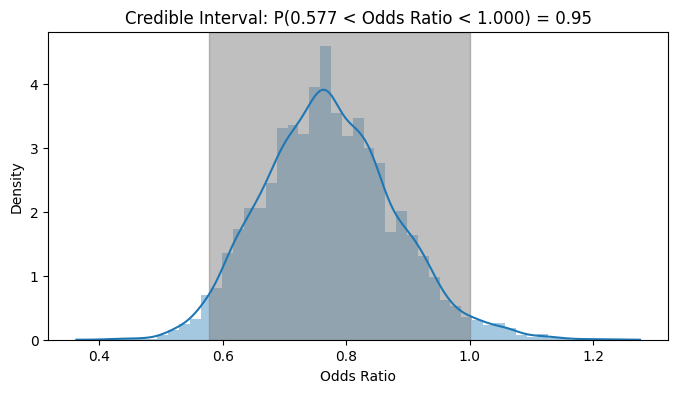

In [137]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.distplot(np.exp(b), axlabel='Odds Ratio', ax=ax)
ax.set_title(f'Credible Interval: P({lb:.3f} < Odds Ratio < {ub:.3f}) = 0.95')
ax.axvspan(lb, ub, alpha=0.5, color='gray');

In [132]:
X_train[:,1]

array([-0.79059004, -0.62395294,  2.01502272,  1.28630821,  0.42007328,
       -0.07121112,  0.01217091, -0.125348  , -0.83014203,  0.26141735,
       -0.23136488,  0.0568156 , -0.74269365, -0.82944208,  1.51925104,
       -0.84832222,  1.28630821, -0.82557519, -0.82292254,  0.28944378,
       -0.83014203,  0.09175784, -0.33086654, -0.47506845,  0.19633638,
       -0.48324994,  0.79244933, -0.70765512, -0.82944208, -0.82944208,
       -0.75507927,  1.42354759, -0.849449  , -0.82292254,  0.74665796,
       -0.79059004, -0.80581754, -0.02378035, -0.82721909,  1.52848542,
       -0.84448772,  1.15579995, -0.81018069,  0.69390887, -0.84532158,
        0.29670816, -0.77662624, -0.79647594,  4.41298506, -0.29067201,
       -0.82557519, -0.81568504, -0.21702301,  1.4282497 ,  0.42007328,
        0.58704727, -0.84843489,  1.30137182,  0.81102063,  1.28445186,
       -0.849449  , -0.82721909, -0.62395294,  1.30137182, -0.84753514,
        1.42319031, -0.83014203, -0.7731739 ,  0.98620196,  1.30